In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import portfolio_metrics as pm
import seaborn as sns

sns.set_style('whitegrid')

In [2]:
df_CleanData = pd.read_csv('data/Clean_FinalData.csv')
#df_CleanData = df_CleanData[df_CleanData['fyear']>2018]
df_CleanData

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps
0,2011-01-31,2011,367204,10001,10.52000,7834.0,8.241368e+04,0.052291,55.0,5510.0,551020.0,55102010.0,0.92,9.0431
1,2011-02-28,2011,367204,10001,10.78000,7834.0,8.445052e+04,0.028992,55.0,5510.0,551020.0,55102010.0,0.92,9.0431
2,2011-03-31,2011,367204,10001,10.98000,7834.0,8.601732e+04,0.022727,55.0,5510.0,551020.0,55102010.0,0.92,9.0431
3,2011-04-29,2011,367204,10001,11.73000,7834.0,9.189282e+04,0.072404,55.0,5510.0,551020.0,55102010.0,0.92,9.0431
4,2011-05-31,2011,367204,10001,11.23000,8151.0,9.153573e+04,-0.038789,55.0,5510.0,551020.0,55102010.0,0.92,9.0431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401487,2020-08-31,2020,88160R,93436,1430.76001,186362.0,2.666393e+08,0.325011,25.0,2510.0,251020.0,25102010.0,-4.92,36.5635
401488,2020-09-30,2020,88160R,93436,498.32001,931809.0,4.643391e+08,0.741452,25.0,2510.0,251020.0,25102010.0,-4.92,36.5635
401489,2020-10-30,2020,88160R,93436,429.01001,948000.0,4.067015e+08,-0.139087,25.0,2510.0,251020.0,25102010.0,-4.92,36.5635
401490,2020-11-30,2020,88160R,93436,388.04001,947901.0,3.678235e+08,-0.095499,25.0,2510.0,251020.0,25102010.0,-4.92,36.5635


In [3]:
#Lagging the compustat datapoints by 3 months to avoid look-ahead bias
# df_CleanData['epspx'] = df_CleanData.sort_values(by=['cusip','fyear'],ascending=False).groupby(['cusip'])['epspx'].shift(-3)
# df_CleanData['bkvlps'] = df_CleanData.sort_values(by=['cusip','fyear'],ascending=False).groupby(['cusip'])['bkvlps'].shift(-3)

# df_CleanData.dropna(subset=['epspx', 'bkvlps'], inplace=True)
# df_CleanData

In [4]:
#GICS Sector mapping

gics_sector = {
10:['Energy'],
15:['Material'],
20:['Industrials'],
25:['Consumer Discretionary'],
30:['Consumer Staples'],
35:['Health Care'],
40:['Financials'],
45:['Information Technology'],
50:['Communication Services'],
55:['Utilities'],
60:['Real Estate']
}

gics_sector = pd.DataFrame.from_dict(gics_sector, orient='index').reset_index().rename(columns={'index':'gsector',0:'GICS_Sector'})
gics_sector

,gsector,GICS_Sector
0,10,Energy
1,15,Material
2,20,Industrials
3,25,Consumer Discretionary
4,30,Consumer Staples
5,35,Health Care
6,40,Financials
7,45,Information Technology
8,50,Communication Services
9,55,Utilities


## Index Universe

In [5]:
#df_IndexUniverse = pd.merge(df_CleanData,df_CleanData.groupby(by=['date']).median().reset_index()[['date', 'mktcap']],on='date',suffixes=('','_Median'))
'''
Defining the Index Universe:
1. Universe: df_CleanData
2. GroupBy: date + gsubind
'''

df_IndexUniverse = pd.merge(df_CleanData, df_CleanData.groupby(by=['date','gsubind']).median()[['mktcap']], right_index=True, left_on=['date','gsubind'], suffixes=('','_Median'))
df_IndexUniverse = df_IndexUniverse[df_IndexUniverse['mktcap']>df_IndexUniverse['mktcap_Median']].reset_index(drop=True).drop(columns=['mktcap_Median'])
df_IndexUniverse

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,2.38,16.5302
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,2.17,22.6289
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,2.70,21.2729
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,2.25,19.0840
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,1.09,5.8703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195817,2011-06-30,2011,53071M,93139,91.14,74056.0,6749463.84,0.107816,25.0,2550.0,255020.0,25502010.0,2.57,15.4056
195818,2011-07-29,2011,53071M,91276,76.76,49222.0,3778280.72,0.020202,25.0,2550.0,255020.0,25502010.0,2.57,15.4056
195819,2011-07-29,2011,53071M,93139,85.75,74131.0,6356733.25,-0.059140,25.0,2550.0,255020.0,25502010.0,2.57,15.4056
195820,2011-08-31,2011,53071M,91276,68.87,49222.0,3389919.14,-0.102788,25.0,2550.0,255020.0,25502010.0,2.57,15.4056


In [6]:
#Visualize number of companies/cusips in each date
sorted({each_date:len(df_IndexUniverse[df_IndexUniverse['date']==each_date]) for each_date in set(df_IndexUniverse['date'])}.items())

[('2011-01-31', 1682),
 ('2011-02-28', 1688),
 ('2011-03-31', 1690),
 ('2011-04-29', 1691),
 ('2011-05-31', 1697),
 ('2011-06-30', 1702),
 ('2011-07-29', 1705),
 ('2011-08-31', 1706),
 ('2011-09-30', 1713),
 ('2011-10-31', 1715),
 ('2011-11-30', 1710),
 ('2011-12-30', 1705),
 ('2012-01-31', 1621),
 ('2012-02-29', 1624),
 ('2012-03-30', 1626),
 ('2012-04-30', 1632),
 ('2012-05-31', 1642),
 ('2012-06-29', 1644),
 ('2012-07-31', 1647),
 ('2012-08-31', 1650),
 ('2012-09-28', 1651),
 ('2012-10-31', 1654),
 ('2012-11-30', 1657),
 ('2012-12-31', 1660),
 ('2013-01-31', 1588),
 ('2013-02-28', 1594),
 ('2013-03-28', 1595),
 ('2013-04-30', 1597),
 ('2013-05-31', 1601),
 ('2013-06-28', 1602),
 ('2013-07-31', 1614),
 ('2013-08-30', 1619),
 ('2013-09-30', 1624),
 ('2013-10-31', 1630),
 ('2013-11-29', 1638),
 ('2013-12-31', 1643),
 ('2014-01-31', 1595),
 ('2014-02-28', 1603),
 ('2014-03-31', 1613),
 ('2014-04-30', 1623),
 ('2014-05-30', 1633),
 ('2014-06-30', 1644),
 ('2014-07-31', 1653),
 ('2014-08-

### Book-Value Per Share modifications

In [7]:
df_SecuritySelection = df_IndexUniverse.copy()

#This is done to give higher weights to undervalued shares compared to overvalued shares
df_SecuritySelection['bkvlps'] = df_SecuritySelection['bkvlps']-df_SecuritySelection['prc']
df_SecuritySelection

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,2.38,-15.0498
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,2.17,-13.1411
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,2.70,-44.3471
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,2.25,-33.7360
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,1.09,-11.5397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195817,2011-06-30,2011,53071M,93139,91.14,74056.0,6749463.84,0.107816,25.0,2550.0,255020.0,25502010.0,2.57,-75.7344
195818,2011-07-29,2011,53071M,91276,76.76,49222.0,3778280.72,0.020202,25.0,2550.0,255020.0,25502010.0,2.57,-61.3544
195819,2011-07-29,2011,53071M,93139,85.75,74131.0,6356733.25,-0.059140,25.0,2550.0,255020.0,25502010.0,2.57,-70.3444
195820,2011-08-31,2011,53071M,91276,68.87,49222.0,3389919.14,-0.102788,25.0,2550.0,255020.0,25502010.0,2.57,-53.4644


## Security Selection

In [8]:
df_SecuritySelection = pd.merge(df_SecuritySelection, df_SecuritySelection.groupby(['date','gsector'])['epspx'].max(), right_index=True, left_on=['date','gsector'], suffixes=('','_Max'))
df_SecuritySelection = pd.merge(df_SecuritySelection, df_SecuritySelection.groupby(['date','gsector'])['bkvlps'].max(), right_index=True, left_on=['date','gsector'], suffixes=('','_Max'))

df_SecuritySelection = pd.merge(df_SecuritySelection, df_SecuritySelection.groupby(['date','gsector'])['epspx'].min(), right_index=True, left_on=['date','gsector'], suffixes=('','_Min'))
df_SecuritySelection = pd.merge(df_SecuritySelection, df_SecuritySelection.groupby(['date','gsector'])['bkvlps'].min(), right_index=True, left_on=['date','gsector'], suffixes=('','_Min'))

df_SecuritySelection['epspx'] = (df_SecuritySelection['epspx'] - df_SecuritySelection['epspx_Min'])/(df_SecuritySelection['epspx_Max'] - df_SecuritySelection['epspx_Min'])
df_SecuritySelection['bkvlps'] = (df_SecuritySelection['bkvlps'] - df_SecuritySelection['bkvlps_Min'])/(df_SecuritySelection['bkvlps_Max'] - df_SecuritySelection['bkvlps_Min'])

df_SecuritySelection

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,0.626506,0.510545,6.72,13.0373,-4.90,-44.3471
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,0.608434,0.543806,6.72,13.0373,-4.90,-44.3471
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,0.654045,0.000000,6.72,13.0373,-4.90,-44.3471
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,0.615318,0.184913,6.72,13.0373,-4.90,-44.3471
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,0.515491,0.571713,6.72,13.0373,-4.90,-44.3471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,101010.0,10101010.0,0.887694,0.983858,10.05,31.6820,-78.28,-1007.7178
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,101020.0,10102050.0,1.000000,0.921734,10.05,31.6820,-78.28,-1007.7178
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,101020.0,10102050.0,0.907393,0.967274,10.05,31.6820,-78.28,-1007.7178
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,101020.0,10102050.0,0.913619,0.943487,10.05,31.6820,-78.28,-1007.7178


In [9]:
#Ranking the Securities
df_SecuritySelection['EPS_Rank'] = df_SecuritySelection.groupby(['date'])['epspx'].transform(lambda x: pd.qcut(x,10, duplicates='drop', labels=range(1,11)))
df_SecuritySelection['BKVLPS_Rank'] = df_SecuritySelection.groupby(['date'])['bkvlps'].transform(lambda x: pd.qcut(x,10,duplicates='drop', labels=range(1,11)))
df_SecuritySelection

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,0.626506,0.510545,6.72,13.0373,-4.90,-44.3471,9,2
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,0.608434,0.543806,6.72,13.0373,-4.90,-44.3471,9,2
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,0.654045,0.000000,6.72,13.0373,-4.90,-44.3471,10,1
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,0.615318,0.184913,6.72,13.0373,-4.90,-44.3471,9,2
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,0.515491,0.571713,6.72,13.0373,-4.90,-44.3471,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,101010.0,10101010.0,0.887694,0.983858,10.05,31.6820,-78.28,-1007.7178,10,10
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,101020.0,10102050.0,1.000000,0.921734,10.05,31.6820,-78.28,-1007.7178,10,6
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,101020.0,10102050.0,0.907393,0.967274,10.05,31.6820,-78.28,-1007.7178,10,8
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,101020.0,10102050.0,0.913619,0.943487,10.05,31.6820,-78.28,-1007.7178,10,7


## Deciling

In [10]:
#Extracting the top decile based on EPS Ranking and BKVLPS Ranking
df_SS_EPS_TopDecile = df_SecuritySelection[df_SecuritySelection['EPS_Rank']==10].reset_index(drop=True)
df_SS_BKVLPS_TopDecile = df_SecuritySelection[df_SecuritySelection['BKVLPS_Rank']==10].reset_index(drop=True)

#Extracting the bottom decile based on EPS Ranking and BKVLPS Ranking
df_SS_EPS_BottomDecile = df_SecuritySelection[df_SecuritySelection['EPS_Rank']==1].reset_index(drop=True)
df_SS_BKVLPS_BottomDecile = df_SecuritySelection[df_SecuritySelection['BKVLPS_Rank']==1].reset_index(drop=True)

## Security Weighting (EPS)

In [11]:
#Based on Market Capitalization
df_SW_MCap_EPS_TopDecile = df_SS_EPS_TopDecile.copy()
df_SW_MCap_EPS_TopDecile = pd.merge(df_SW_MCap_EPS_TopDecile, df_SW_MCap_EPS_TopDecile.groupby(['date'])['mktcap'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_MCap_EPS_TopDecile['Weight'] = df_SW_MCap_EPS_TopDecile['mktcap']/df_SW_MCap_EPS_TopDecile['mktcap_sum']
df_SW_MCap_EPS_TopDecile['Weighted_Ret'] = df_SW_MCap_EPS_TopDecile['Weight']*df_SW_MCap_EPS_TopDecile['ret']
df_SW_MCap_EPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,mktcap_sum,Weight,Weighted_Ret
0,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,...,0.000000,6.72,13.0373,-4.90,-44.3471,10,1,3.316670e+09,0.001626,0.000067
1,2011-01-31,2011,646025,64450,43.11,41288.0,1779925.68,0.008351,55.0,5510.0,...,0.328608,6.72,13.0373,-4.90,-44.3471,10,2,3.316670e+09,0.000537,0.000004
2,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.569010,6.72,13.0373,-4.90,-44.3471,10,3,3.316670e+09,0.004342,0.000108
3,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.674431,6.72,13.0373,-4.90,-44.3471,10,3,3.316670e+09,0.002311,0.000069
4,2011-01-31,2011,80589M,23085,40.60,127223.0,5165253.80,0.011201,55.0,5510.0,...,0.573269,6.72,13.0373,-4.90,-44.3471,10,3,3.316670e+09,0.001557,0.000017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,2020-12-31,2020,703481,79857,4.31,187494.0,808099.14,0.683594,10.0,1010.0,...,0.693449,14.42,43.3660,-64.34,-64.0233,10,4,9.329644e+09,0.000087,0.000059
17021,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,0.678961,14.42,43.3660,-64.34,-64.0233,10,4,9.329644e+09,0.000054,0.000005
17022,2020-12-31,2020,629579,28118,26.75,5477.0,146509.75,0.382376,10.0,1010.0,...,0.733935,14.42,43.3660,-64.34,-64.0233,10,4,9.329644e+09,0.000016,0.000006
17023,2020-12-31,2020,15643U,86233,14.99,11321.0,169701.79,0.543769,10.0,1010.0,...,0.000000,14.42,43.3660,-64.34,-64.0233,10,1,9.329644e+09,0.000018,0.000010


In [12]:
sorted({each_date:len(df_SW_MCap_EPS_TopDecile[df_SW_MCap_EPS_TopDecile['date']==each_date]) for each_date in set(df_SW_MCap_EPS_TopDecile['date'])}.items())

[('2011-01-31', 168),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 165),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 159),
 ('2013-09-30', 162),
 ('2013-10-31', 161),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 164),
 ('2014-07-31', 165),
 ('2014-08-29', 167),
 ('2014-09-30', 166),
 ('2014-10

In [13]:
#Monthly Index Returns
idx_Return_mcap_eps_TopDecile =df_SW_MCap_EPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_mcap_eps_TopDecile

date
2011-01-31    0.064548
2011-02-28    0.038637
2011-03-31    0.037751
2011-04-29    0.006471
2011-05-31    0.030313
                ...   
2020-08-31    0.057006
2020-09-30    0.103478
2020-10-30   -0.046711
2020-11-30   -0.023337
2020-12-31    0.100967
Name: Weighted_Ret, Length: 120, dtype: float64

In [14]:
df_idx_Return_mcap_eps_TopDecile = pd.DataFrame(idx_Return_mcap_eps_TopDecile).reset_index()
df_idx_Return_mcap_eps_TopDecile['date'] = pd.to_datetime(df_idx_Return_mcap_eps_TopDecile['date'])

TS_Mcap_EPS = pm.tear_sheet(df_idx_Return_mcap_eps_TopDecile.copy(),df_SW_MCap_EPS_TopDecile.copy())
TS_Mcap_EPS

C:\Users\amaya\Desktop\MS QCF\Index Project\portfolio_metrics.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  return (mean_ret_A(data,duration)-rf)/sd_ret_neg_A(data,duration)


,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.168783,0.136000,0.171919,0.171919,1.093990,2.299843,-0.102216,0.044994
1,2012,0.214224,0.109948,0.229254,0.440586,1.766507,3.022445,-0.055340,0.052641
2,2013,0.262346,0.094520,0.290785,0.859487,2.563954,9.400551,-0.023254,0.015931
3,2014,0.208554,0.088626,0.224989,1.277850,2.127530,6.243501,-0.032085,0.091514
4,2015,0.095182,0.118575,0.091829,1.487022,0.634050,0.823545,-0.094428,0.015955
5,2016,0.108682,0.104809,0.108262,1.756271,0.846125,1.897019,-0.044176,0.035417
6,2017,0.339250,0.061294,0.394824,2.844514,5.208465,inf,-0.006705,0.028628
7,2018,0.116814,0.137273,0.112728,3.277896,0.705261,1.044722,-0.103758,0.030452
8,2019,0.208032,0.162713,0.212935,4.188810,1.155606,1.845993,-0.065907,0.057883
9,2020,0.352797,0.248952,0.374381,6.131404,1.336789,3.676510,-0.161948,0.074244


In [15]:
idx_sector_mcap_eps_TopDecile = pd.DataFrame(df_SW_MCap_EPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_mcap_eps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.249283
1,2011-01-31,15.0,0.018538
2,2011-01-31,20.0,0.084813
3,2011-01-31,25.0,0.002764
4,2011-01-31,30.0,0.000730
...,...,...,...
1315,2020-12-31,40.0,0.001438
1316,2020-12-31,45.0,0.678510
1317,2020-12-31,50.0,0.118814
1318,2020-12-31,55.0,0.090250


#### Sectoral Analysis

In [16]:
sector_weights = pd.merge((idx_sector_mcap_eps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,17.705343
1,Material,0.561355
2,Industrials,9.506833
3,Consumer Discretionary,0.552425
4,Consumer Staples,2.214149
5,Health Care,21.453579
6,Financials,6.417934
7,Information Technology,28.392630
8,Communication Services,7.891651
9,Utilities,4.978180


In [17]:
#Based on Equal Weight
df_SW_EqWt_EPS_TopDecile = df_SS_EPS_TopDecile.copy()
df_SW_EqWt_EPS_TopDecile = pd.merge(df_SW_EqWt_EPS_TopDecile, 1/df_SW_EqWt_EPS_TopDecile.groupby(['date'])['cusip'].count(), right_index=True, left_on='date', suffixes=('','_wgt')) 
df_SW_EqWt_EPS_TopDecile.rename(columns={'cusip_wgt':'Weight'}, inplace=True)
df_SW_EqWt_EPS_TopDecile['Weighted_Ret'] = df_SW_EqWt_EPS_TopDecile['Weight']*df_SW_EqWt_EPS_TopDecile['ret']
df_SW_EqWt_EPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,epspx,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,Weight,Weighted_Ret
0,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,...,0.654045,0.000000,6.72,13.0373,-4.90,-44.3471,10,1,0.005952,0.000245
1,2011-01-31,2011,646025,64450,43.11,41288.0,1779925.68,0.008351,55.0,5510.0,...,0.666093,0.328608,6.72,13.0373,-4.90,-44.3471,10,2,0.005952,0.000050
2,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.722031,0.569010,6.72,13.0373,-4.90,-44.3471,10,3,0.005952,0.000148
3,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.744406,0.674431,6.72,13.0373,-4.90,-44.3471,10,3,0.005952,0.000178
4,2011-01-31,2011,80589M,23085,40.60,127223.0,5165253.80,0.011201,55.0,5510.0,...,0.679002,0.573269,6.72,13.0373,-4.90,-44.3471,10,3,0.005952,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,2020-12-31,2020,703481,79857,4.31,187494.0,808099.14,0.683594,10.0,1010.0,...,0.790249,0.693449,14.42,43.3660,-64.34,-64.0233,10,4,0.005952,0.004069
17021,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,1.000000,0.678961,14.42,43.3660,-64.34,-64.0233,10,4,0.005952,0.000563
17022,2020-12-31,2020,629579,28118,26.75,5477.0,146509.75,0.382376,10.0,1010.0,...,0.889030,0.733935,14.42,43.3660,-64.34,-64.0233,10,4,0.005952,0.002276
17023,2020-12-31,2020,15643U,86233,14.99,11321.0,169701.79,0.543769,10.0,1010.0,...,0.784662,0.000000,14.42,43.3660,-64.34,-64.0233,10,1,0.005952,0.003237


In [18]:
sorted({each_date:len(df_SW_EqWt_EPS_TopDecile[df_SW_EqWt_EPS_TopDecile['date']==each_date]) for each_date in set(df_SW_EqWt_EPS_TopDecile['date'])}.items())

[('2011-01-31', 168),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 165),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 159),
 ('2013-09-30', 162),
 ('2013-10-31', 161),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 164),
 ('2014-07-31', 165),
 ('2014-08-29', 167),
 ('2014-09-30', 166),
 ('2014-10

In [19]:
#Monthly Index Returns
idx_Return_eqwt_eps_TopDecile =df_SW_EqWt_EPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_eqwt_eps_TopDecile

date
2011-01-31    0.077343
2011-02-28    0.026386
2011-03-31    0.042919
2011-04-29    0.021293
2011-05-31    0.024909
                ...   
2020-08-31    0.019651
2020-09-30    0.025639
2020-10-30   -0.078272
2020-11-30   -0.007218
2020-12-31    0.228811
Name: Weighted_Ret, Length: 120, dtype: float64

In [20]:
df_idx_Return_eqwt_eps_TopDecile = pd.DataFrame(idx_Return_eqwt_eps_TopDecile).reset_index()
df_idx_Return_eqwt_eps_TopDecile['date'] = pd.to_datetime(df_idx_Return_eqwt_eps_TopDecile['date'])

TS_EqWt_EPS = pm.tear_sheet(df_idx_Return_eqwt_eps_TopDecile.copy(),df_SW_EqWt_EPS_TopDecile.copy())
TS_EqWt_EPS

C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.098069,0.177213,0.085642,0.085642,0.440540,0.757510,-0.184275,0.044994
1,2012,0.186876,0.113893,0.196046,0.298478,1.465199,2.312459,-0.066175,0.052641
2,2013,0.353669,0.101589,0.410079,0.830957,3.284505,31.788183,-0.019370,0.015931
3,2014,0.202279,0.109677,0.214988,1.224591,1.661956,4.297751,-0.035411,0.091514
4,2015,0.154568,0.149456,0.152995,1.564942,0.900384,1.668998,-0.136369,0.015955
5,2016,0.195075,0.181176,0.194537,2.063918,0.966325,3.450513,-0.071084,0.035417
6,2017,0.271392,0.045617,0.306529,3.003097,5.510884,NaN,0.000000,0.028628
7,2018,0.012142,0.162738,-0.001574,2.996796,-0.048284,-0.070199,-0.140882,0.030452
8,2019,0.100558,0.187685,0.085887,3.340068,0.429216,0.610224,-0.077571,0.057883
9,2020,0.162028,0.548789,0.017661,3.416717,0.258802,0.462600,-0.425487,0.074244


In [21]:
idx_sector_eqwt_eps_TopDecile = pd.DataFrame(df_SW_EqWt_EPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_eqwt_eps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.113095
1,2011-01-31,15.0,0.017857
2,2011-01-31,20.0,0.119048
3,2011-01-31,25.0,0.023810
4,2011-01-31,30.0,0.005952
...,...,...,...
1315,2020-12-31,40.0,0.005952
1316,2020-12-31,45.0,0.255952
1317,2020-12-31,50.0,0.017857
1318,2020-12-31,55.0,0.190476


#### Sectoral Analysis

In [22]:
sector_weights = pd.merge((idx_sector_eqwt_eps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,18.970712
1,Material,1.166007
2,Industrials,14.296791
3,Consumer Discretionary,1.317963
4,Consumer Staples,2.887225
5,Health Care,26.315435
6,Financials,9.474936
7,Information Technology,15.675483
8,Communication Services,1.212636
9,Utilities,7.062938


In [23]:
#Based on Alternative Weighing Mechanism
df_SW_AWM_EPS_TopDecile = df_SS_EPS_TopDecile.copy()
df_SW_AWM_EPS_TopDecile = pd.merge(df_SW_AWM_EPS_TopDecile, df_SW_AWM_EPS_TopDecile.groupby(['date'])['epspx'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_AWM_EPS_TopDecile['Weight'] = df_SW_AWM_EPS_TopDecile['epspx']/df_SW_AWM_EPS_TopDecile['epspx_sum']
df_SW_AWM_EPS_TopDecile['Weighted_Ret'] = df_SW_AWM_EPS_TopDecile['Weight']*df_SW_AWM_EPS_TopDecile['ret']
df_SW_AWM_EPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,epspx_sum,Weight,Weighted_Ret
0,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,...,0.000000,6.72,13.0373,-4.90,-44.3471,10,1,123.873134,0.005280,0.000217
1,2011-01-31,2011,646025,64450,43.11,41288.0,1779925.68,0.008351,55.0,5510.0,...,0.328608,6.72,13.0373,-4.90,-44.3471,10,2,123.873134,0.005377,0.000045
2,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.569010,6.72,13.0373,-4.90,-44.3471,10,3,123.873134,0.005829,0.000145
3,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.674431,6.72,13.0373,-4.90,-44.3471,10,3,123.873134,0.006009,0.000179
4,2011-01-31,2011,80589M,23085,40.60,127223.0,5165253.80,0.011201,55.0,5510.0,...,0.573269,6.72,13.0373,-4.90,-44.3471,10,3,123.873134,0.005481,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17020,2020-12-31,2020,703481,79857,4.31,187494.0,808099.14,0.683594,10.0,1010.0,...,0.693449,14.42,43.3660,-64.34,-64.0233,10,4,135.668538,0.005825,0.003982
17021,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,0.678961,14.42,43.3660,-64.34,-64.0233,10,4,135.668538,0.007371,0.000697
17022,2020-12-31,2020,629579,28118,26.75,5477.0,146509.75,0.382376,10.0,1010.0,...,0.733935,14.42,43.3660,-64.34,-64.0233,10,4,135.668538,0.006553,0.002506
17023,2020-12-31,2020,15643U,86233,14.99,11321.0,169701.79,0.543769,10.0,1010.0,...,0.000000,14.42,43.3660,-64.34,-64.0233,10,1,135.668538,0.005784,0.003145


In [24]:
sorted({each_date:len(df_SW_AWM_EPS_TopDecile[df_SW_AWM_EPS_TopDecile['date']==each_date]) for each_date in set(df_SW_AWM_EPS_TopDecile['date'])}.items())

[('2011-01-31', 168),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 165),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 159),
 ('2013-09-30', 162),
 ('2013-10-31', 161),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 164),
 ('2014-07-31', 165),
 ('2014-08-29', 167),
 ('2014-09-30', 166),
 ('2014-10

In [25]:
#Monthly Index Returns
idx_Return_awm_eps_TopDecile =df_SW_AWM_EPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_awm_eps_TopDecile

date
2011-01-31    0.075643
2011-02-28    0.027867
2011-03-31    0.042238
2011-04-29    0.019844
2011-05-31    0.023339
                ...   
2020-08-31    0.020006
2020-09-30    0.024747
2020-10-30   -0.078444
2020-11-30   -0.007353
2020-12-31    0.229401
Name: Weighted_Ret, Length: 120, dtype: float64

In [26]:
df_idx_Return_awm_eps_TopDecile = pd.DataFrame(idx_Return_awm_eps_TopDecile).reset_index()
df_idx_Return_awm_eps_TopDecile['date'] = pd.to_datetime(df_idx_Return_awm_eps_TopDecile['date'])

TS_AWM_EPS = pm.tear_sheet(df_idx_Return_awm_eps_TopDecile.copy(),df_SW_AWM_EPS_TopDecile.copy())
TS_AWM_EPS

C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.097727,0.177260,0.085276,0.085276,0.438494,0.754801,-0.183840,0.044994
1,2012,0.186937,0.112932,0.196249,0.298261,1.478210,2.339810,-0.065175,0.052641
2,2013,0.350087,0.100490,0.405325,0.824479,3.284784,28.055958,-0.019584,0.015931
3,2014,0.201573,0.108830,0.214253,1.215378,1.668409,4.235628,-0.035325,0.091514
4,2015,0.153048,0.148385,0.151454,1.550906,0.896645,1.670966,-0.135347,0.015955
5,2016,0.191646,0.181035,0.190572,2.037036,0.948136,3.447205,-0.071334,0.035417
6,2017,0.268872,0.043971,0.303405,2.958489,5.659896,NaN,0.000000,0.028628
7,2018,0.004438,0.165120,-0.009629,2.920373,-0.094246,-0.144706,-0.143982,0.030452
8,2019,0.110095,0.182855,0.097251,3.301632,0.492710,0.709372,-0.074702,0.057883
9,2020,0.154834,0.556097,0.006259,3.328557,0.242466,0.429604,-0.432333,0.074244


In [27]:
idx_sector_awm_eps_TopDecile = pd.DataFrame(df_SW_AWM_EPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_awm_eps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.115684
1,2011-01-31,15.0,0.021072
2,2011-01-31,20.0,0.122141
3,2011-01-31,25.0,0.027395
4,2011-01-31,30.0,0.008073
...,...,...,...
1315,2020-12-31,40.0,0.007371
1316,2020-12-31,45.0,0.241637
1317,2020-12-31,50.0,0.018604
1318,2020-12-31,55.0,0.188804


#### Sectoral Analysis

In [28]:
sector_weights = pd.merge((idx_sector_awm_eps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,19.484141
1,Material,1.355511
2,Industrials,14.226288
3,Consumer Discretionary,1.581489
4,Consumer Staples,2.857828
5,Health Care,25.732487
6,Financials,9.322904
7,Information Technology,14.754613
8,Communication Services,1.492068
9,Utilities,7.354516


In [ ]:
#Based on Optimization - WIP
df_SW_Opt_EPS_TopDecile = df_SS_EPS_TopDecile.copy()


## Security Weighting (BKVLPS)

In [29]:
#Based on Market Capitalization
df_SW_Mcap_BKVLPS_TopDecile = df_SS_BKVLPS_TopDecile.copy()
df_SW_Mcap_BKVLPS_TopDecile = pd.merge(df_SW_Mcap_BKVLPS_TopDecile, df_SW_Mcap_BKVLPS_TopDecile.groupby(['date'])['mktcap'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_Mcap_BKVLPS_TopDecile['Weight'] = df_SW_Mcap_BKVLPS_TopDecile['mktcap']/df_SW_Mcap_BKVLPS_TopDecile['mktcap_sum']
df_SW_Mcap_BKVLPS_TopDecile['Weighted_Ret'] = df_SW_Mcap_BKVLPS_TopDecile['Weight']*df_SW_Mcap_BKVLPS_TopDecile['ret']
df_SW_Mcap_BKVLPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,mktcap_sum,Weight,Weighted_Ret
0,2011-01-31,2011,629377,90071,19.54,247197.0,4.830229e+06,0.008256,55.0,5510.0,...,1.000000,6.72,13.0373,-4.90,-44.3471,9,10,6.072702e+08,0.007954,0.000066
80,2011-01-31,2011,302520,10629,9.82,114642.0,1.125784e+06,0.119726,40.0,4010.0,...,0.999825,27.31,20.4948,-16.55,-120386.3647,5,10,6.072702e+08,0.001854,0.000222
81,2011-01-31,2011,947890,10932,19.70,87227.0,1.718372e+06,0.193939,40.0,4010.0,...,0.999833,27.31,20.4948,-16.55,-120386.3647,5,10,6.072702e+08,0.002830,0.000549
82,2011-01-31,2011,318672,11018,0.46,319558.0,1.469967e+05,0.916667,40.0,4010.0,...,0.999841,27.31,20.4948,-16.55,-120386.3647,4,10,6.072702e+08,0.000242,0.000222
83,2011-01-31,2011,67103X,11208,12.49,46317.0,5.784993e+05,0.081034,40.0,4010.0,...,0.999845,27.31,20.4948,-16.55,-120386.3647,4,10,6.072702e+08,0.000953,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19178,2020-12-31,2020,46269C,92596,32.09,133302.0,4.277661e+06,0.215070,50.0,5010.0,...,0.999811,65.88,33.5319,-2.57,-289029.7300,1,10,4.140020e+09,0.001033,0.000222
19319,2020-12-31,2020,893617,89317,26.09,8718.0,2.274526e+05,0.185909,60.0,6010.0,...,1.000000,10.98,12.0613,-3.09,-113.3678,1,10,4.140020e+09,0.000055,0.000010
19380,2020-12-31,2020,05351W,15859,46.54,309010.0,1.438133e+07,-0.056749,55.0,5510.0,...,1.000000,7.82,2.7699,-14.50,-119.5273,10,10,4.140020e+09,0.003474,-0.000197
19381,2020-12-31,2020,65339F,24205,73.59,1959074.0,1.441683e+08,0.009971,55.0,5510.0,...,0.994398,7.82,2.7699,-14.50,-119.5273,10,10,4.140020e+09,0.034823,0.000347


In [30]:
sorted({each_date:len(df_SW_Mcap_BKVLPS_TopDecile[df_SW_Mcap_BKVLPS_TopDecile['date']==each_date]) for each_date in set(df_SW_Mcap_BKVLPS_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [31]:
#Monthly Index Returns
idx_Return_mcap_bkvlps_TopDecile =df_SW_Mcap_BKVLPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_mcap_bkvlps_TopDecile

date
2011-01-31    0.131903
2011-02-28   -0.000010
2011-03-31    0.021243
2011-04-29   -0.029395
2011-05-31    0.002298
                ...   
2020-08-31    0.075252
2020-09-30    0.061941
2020-10-30   -0.027361
2020-11-30    0.025888
2020-12-31    0.097071
Name: Weighted_Ret, Length: 120, dtype: float64

In [32]:
df_idx_Return_mcap_bkvlps_TopDecile = pd.DataFrame(idx_Return_mcap_bkvlps_TopDecile).reset_index()
df_idx_Return_mcap_bkvlps_TopDecile['date'] = pd.to_datetime(df_idx_Return_mcap_bkvlps_TopDecile['date'])

TS_Mcap_BKPS = pm.tear_sheet(df_idx_Return_mcap_bkvlps_TopDecile.copy(),df_SW_Mcap_BKVLPS_TopDecile.copy())
TS_Mcap_BKPS

,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,-0.124273,0.282341,-0.151512,-0.151512,-0.510987,-1.016699,-0.330643,0.112984
1,2012,0.229390,0.199437,0.230186,0.043798,1.049906,1.326298,-0.151252,0.077482
2,2013,0.408288,0.116193,0.484609,0.549633,3.341760,9.620721,-0.029860,0.193221
3,2014,0.016327,0.137979,0.006660,0.559954,-0.026621,-0.119305,-0.083566,0.239905
4,2015,-0.086392,0.151813,-0.093588,0.413961,-0.700813,-1.234940,-0.182147,0.168871
5,2016,0.083707,0.171935,0.071180,0.514607,0.370529,0.596422,-0.090689,0.284621
6,2017,0.058921,0.071341,0.057866,0.602252,0.545563,1.047220,-0.056272,0.197358
7,2018,-0.096436,0.083712,-0.095561,0.449140,-1.390922,-1.668782,-0.121320,0.212489
8,2019,0.058609,0.226755,0.032960,0.496904,0.170266,0.270375,-0.092475,0.124587
9,2020,0.181622,0.323563,0.135941,0.700395,0.499508,0.853466,-0.322286,0.256678


In [33]:
idx_sector_mcap_bkvlps_TopDecile = pd.DataFrame(df_SW_Mcap_BKVLPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_mcap_bkvlps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.001311
1,2011-01-31,15.0,0.001957
2,2011-01-31,20.0,0.005670
3,2011-01-31,25.0,0.004379
4,2011-01-31,30.0,0.000311
...,...,...,...
1315,2020-12-31,40.0,0.000069
1316,2020-12-31,45.0,0.001349
1317,2020-12-31,50.0,0.934275
1318,2020-12-31,55.0,0.038297


#### Sectoral Analysis

In [34]:
sector_weights = pd.merge((idx_sector_mcap_bkvlps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,0.830495
1,Material,1.926251
2,Industrials,0.969186
3,Consumer Discretionary,25.809070
4,Consumer Staples,14.126892
5,Health Care,7.145566
6,Financials,32.490115
7,Information Technology,3.141814
8,Communication Services,11.774324
9,Utilities,1.689475


In [35]:
#Based on Equal Weight
df_SW_EqWt_BKVLPS_TopDecile = df_SS_BKVLPS_TopDecile.copy()
df_SW_EqWt_BKVLPS_TopDecile = pd.merge(df_SW_EqWt_BKVLPS_TopDecile, 1/df_SW_EqWt_BKVLPS_TopDecile.groupby(['date'])['cusip'].count(), right_index=True, left_on='date', suffixes=('','_wgt')) 
df_SW_EqWt_BKVLPS_TopDecile.rename(columns={'cusip_wgt':'Weight'}, inplace=True)
df_SW_EqWt_BKVLPS_TopDecile['Weighted_Ret'] = df_SW_EqWt_BKVLPS_TopDecile['Weight']*df_SW_EqWt_BKVLPS_TopDecile['ret']
df_SW_EqWt_BKVLPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,epspx,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,Weight,Weighted_Ret
0,2011-01-31,2011,629377,90071,19.54,247197.0,4.830229e+06,0.008256,55.0,5510.0,...,0.581756,1.000000,6.72,13.0373,-4.90,-44.3471,9,10,0.005917,0.000049
80,2011-01-31,2011,302520,10629,9.82,114642.0,1.125784e+06,0.119726,40.0,4010.0,...,0.392385,0.999825,27.31,20.4948,-16.55,-120386.3647,5,10,0.005917,0.000708
81,2011-01-31,2011,947890,10932,19.70,87227.0,1.718372e+06,0.193939,40.0,4010.0,...,0.391701,0.999833,27.31,20.4948,-16.55,-120386.3647,5,10,0.005917,0.001148
82,2011-01-31,2011,318672,11018,0.46,319558.0,1.469967e+05,0.916667,40.0,4010.0,...,0.360921,0.999841,27.31,20.4948,-16.55,-120386.3647,4,10,0.005917,0.005424
83,2011-01-31,2011,67103X,11208,12.49,46317.0,5.784993e+05,0.081034,40.0,4010.0,...,0.365937,0.999845,27.31,20.4948,-16.55,-120386.3647,4,10,0.005917,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19178,2020-12-31,2020,46269C,92596,32.09,133302.0,4.277661e+06,0.215070,50.0,5010.0,...,0.018115,0.999811,65.88,33.5319,-2.57,-289029.7300,1,10,0.005952,0.001280
19319,2020-12-31,2020,893617,89317,26.09,8718.0,2.274526e+05,0.185909,60.0,6010.0,...,0.000000,1.000000,10.98,12.0613,-3.09,-113.3678,1,10,0.005952,0.001107
19380,2020-12-31,2020,05351W,15859,46.54,309010.0,1.438133e+07,-0.056749,55.0,5510.0,...,0.750896,1.000000,7.82,2.7699,-14.50,-119.5273,10,10,0.005952,-0.000338
19381,2020-12-31,2020,65339F,24205,73.59,1959074.0,1.441683e+08,0.009971,55.0,5510.0,...,1.000000,0.994398,7.82,2.7699,-14.50,-119.5273,10,10,0.005952,0.000059


In [36]:
sorted({each_date:len(df_SW_EqWt_BKVLPS_TopDecile[df_SW_EqWt_BKVLPS_TopDecile['date']==each_date]) for each_date in set(df_SW_EqWt_BKVLPS_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [37]:
#Monthly Index Returns
idx_Return_eqwt_bkvlps_TopDecile =df_SW_EqWt_BKVLPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_eqwt_bkvlps_TopDecile

date
2011-01-31    0.116332
2011-02-28   -0.004569
2011-03-31    0.026722
2011-04-29   -0.001149
2011-05-31    0.007621
                ...   
2020-08-31    0.005483
2020-09-30    0.049637
2020-10-30   -0.040470
2020-11-30   -0.005796
2020-12-31    0.227137
Name: Weighted_Ret, Length: 120, dtype: float64

In [38]:
df_idx_Return_eqwt_bkvlps_TopDecile = pd.DataFrame(idx_Return_eqwt_bkvlps_TopDecile).reset_index()
df_idx_Return_eqwt_bkvlps_TopDecile['date'] = pd.to_datetime(df_idx_Return_eqwt_bkvlps_TopDecile['date'])

TS_EqWt_BKPS = pm.tear_sheet(df_idx_Return_eqwt_bkvlps_TopDecile.copy(),df_SW_EqWt_BKVLPS_TopDecile.copy())
TS_EqWt_BKPS

,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,-0.045102,0.237323,-0.070305,-0.070305,-0.274317,-0.518777,-0.272442,0.112984
1,2012,0.208927,0.123783,0.220912,0.135077,1.526282,2.411015,-0.080161,0.077482
2,2013,0.342590,0.119778,0.392268,0.580331,2.693223,5.783618,-0.042291,0.193221
3,2014,0.102632,0.190927,0.087779,0.719050,0.432793,1.689915,-0.086116,0.239905
4,2015,-0.053992,0.196770,-0.071595,0.595975,-0.376032,-0.506718,-0.223866,0.168871
5,2016,0.074472,0.187488,0.058426,0.689221,0.290536,0.546413,-0.094098,0.284621
6,2017,0.154384,0.110754,0.158959,0.957738,1.213352,2.794292,-0.037689,0.197358
7,2018,0.002473,0.140808,-0.007931,0.942210,-0.124472,-0.116289,-0.124868,0.212489
8,2019,0.023064,0.259337,-0.011280,0.920302,0.011816,0.019027,-0.141540,0.124587
9,2020,0.377873,0.355528,0.366514,1.624118,1.006596,1.877173,-0.250916,0.256678


In [39]:
idx_sector_eqwt_bkvlps_TopDecile = pd.DataFrame(df_SW_EqWt_BKVLPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_eqwt_bkvlps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.005917
1,2011-01-31,15.0,0.005917
2,2011-01-31,20.0,0.005917
3,2011-01-31,25.0,0.005917
4,2011-01-31,30.0,0.005917
...,...,...,...
1315,2020-12-31,40.0,0.005952
1316,2020-12-31,45.0,0.005952
1317,2020-12-31,50.0,0.458333
1318,2020-12-31,55.0,0.011905


#### Sectoral Analysis

In [40]:
sector_weights = pd.merge((idx_sector_eqwt_bkvlps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,1.301332
1,Material,1.942311
2,Industrials,1.555467
3,Consumer Discretionary,25.919264
4,Consumer Staples,6.438476
5,Health Care,20.265958
6,Financials,28.883099
7,Information Technology,4.580264
8,Communication Services,7.669453
9,Utilities,0.724275


In [41]:
#Based on Alternative Weighing Mechanism
df_SW_AWM_BKVLPS_TopDecile = df_SS_BKVLPS_TopDecile.copy()
df_SW_AWM_BKVLPS_TopDecile = pd.merge(df_SW_AWM_BKVLPS_TopDecile, df_SW_AWM_BKVLPS_TopDecile.groupby(['date'])['bkvlps'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_AWM_BKVLPS_TopDecile['Weight'] = df_SW_AWM_BKVLPS_TopDecile['bkvlps']/df_SW_AWM_BKVLPS_TopDecile['bkvlps_sum']
df_SW_AWM_BKVLPS_TopDecile['Weighted_Ret'] = df_SW_AWM_BKVLPS_TopDecile['Weight']*df_SW_AWM_BKVLPS_TopDecile['ret']
df_SW_AWM_BKVLPS_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,bkvlps,epspx_Max,bkvlps_Max,epspx_Min,bkvlps_Min,EPS_Rank,BKVLPS_Rank,bkvlps_sum,Weight,Weighted_Ret
0,2011-01-31,2011,629377,90071,19.54,247197.0,4.830229e+06,0.008256,55.0,5510.0,...,1.000000,6.72,13.0373,-4.90,-44.3471,9,10,168.975729,0.005918,0.000049
80,2011-01-31,2011,302520,10629,9.82,114642.0,1.125784e+06,0.119726,40.0,4010.0,...,0.999825,27.31,20.4948,-16.55,-120386.3647,5,10,168.975729,0.005917,0.000708
81,2011-01-31,2011,947890,10932,19.70,87227.0,1.718372e+06,0.193939,40.0,4010.0,...,0.999833,27.31,20.4948,-16.55,-120386.3647,5,10,168.975729,0.005917,0.001148
82,2011-01-31,2011,318672,11018,0.46,319558.0,1.469967e+05,0.916667,40.0,4010.0,...,0.999841,27.31,20.4948,-16.55,-120386.3647,4,10,168.975729,0.005917,0.005424
83,2011-01-31,2011,67103X,11208,12.49,46317.0,5.784993e+05,0.081034,40.0,4010.0,...,0.999845,27.31,20.4948,-16.55,-120386.3647,4,10,168.975729,0.005917,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19178,2020-12-31,2020,46269C,92596,32.09,133302.0,4.277661e+06,0.215070,50.0,5010.0,...,0.999811,65.88,33.5319,-2.57,-289029.7300,1,10,167.369584,0.005974,0.001285
19319,2020-12-31,2020,893617,89317,26.09,8718.0,2.274526e+05,0.185909,60.0,6010.0,...,1.000000,10.98,12.0613,-3.09,-113.3678,1,10,167.369584,0.005975,0.001111
19380,2020-12-31,2020,05351W,15859,46.54,309010.0,1.438133e+07,-0.056749,55.0,5510.0,...,1.000000,7.82,2.7699,-14.50,-119.5273,10,10,167.369584,0.005975,-0.000339
19381,2020-12-31,2020,65339F,24205,73.59,1959074.0,1.441683e+08,0.009971,55.0,5510.0,...,0.994398,7.82,2.7699,-14.50,-119.5273,10,10,167.369584,0.005941,0.000059


In [42]:
sorted({each_date:len(df_SW_AWM_BKVLPS_TopDecile[df_SW_AWM_BKVLPS_TopDecile['date']==each_date]) for each_date in set(df_SW_AWM_BKVLPS_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [43]:
#Monthly Index Returns
idx_Return_awm_bkvlps_TopDecile =df_SW_AWM_BKVLPS_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_awm_bkvlps_TopDecile

date
2011-01-31    0.116332
2011-02-28   -0.004568
2011-03-31    0.026721
2011-04-29   -0.001149
2011-05-31    0.007621
                ...   
2020-08-31    0.005743
2020-09-30    0.049593
2020-10-30   -0.040430
2020-11-30   -0.005732
2020-12-31    0.227186
Name: Weighted_Ret, Length: 120, dtype: float64

In [44]:
df_idx_Return_awm_bkvlps_TopDecile = pd.DataFrame(idx_Return_awm_bkvlps_TopDecile).reset_index()
df_idx_Return_awm_bkvlps_TopDecile['date'] = pd.to_datetime(df_idx_Return_awm_bkvlps_TopDecile['date'])

TS_AWM_BKPS = pm.tear_sheet(df_idx_Return_awm_bkvlps_TopDecile.copy(),df_SW_AWM_BKVLPS_TopDecile.copy())
TS_AWM_BKPS

,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,-0.045106,0.237324,-0.070309,-0.070309,-0.274336,-0.518809,-0.272445,0.112984
1,2012,0.208938,0.123788,0.220925,0.135083,1.526304,2.411308,-0.080168,0.077482
2,2013,0.342411,0.119780,0.392026,0.580064,2.691697,5.780775,-0.042310,0.193221
3,2014,0.102227,0.190959,0.087334,0.718058,0.430600,1.681309,-0.086311,0.239905
4,2015,-0.054837,0.196661,-0.072365,0.593731,-0.380538,-0.512833,-0.223960,0.168871
5,2016,0.074013,0.187681,0.057902,0.686011,0.287789,0.540262,-0.094363,0.284621
6,2017,0.153554,0.110519,0.158038,0.952464,1.208429,2.781534,-0.037544,0.197358
7,2018,0.002224,0.140735,-0.008169,0.936515,-0.126306,-0.117911,-0.124802,0.212489
8,2019,0.022600,0.259409,-0.011758,0.913745,0.010022,0.016164,-0.141770,0.124587
9,2020,0.377304,0.355682,0.365670,1.613544,1.004561,1.869751,-0.251348,0.256678


In [45]:
idx_sector_awm_bkvlps_TopDecile = pd.DataFrame(df_SW_AWM_BKVLPS_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_awm_bkvlps_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.005918
1,2011-01-31,15.0,0.005918
2,2011-01-31,20.0,0.005918
3,2011-01-31,25.0,0.005918
4,2011-01-31,30.0,0.005918
...,...,...,...
1315,2020-12-31,40.0,0.005975
1316,2020-12-31,45.0,0.005975
1317,2020-12-31,50.0,0.459832
1318,2020-12-31,55.0,0.011916


#### Sectoral Analysis

In [46]:
sector_weights = pd.merge((idx_sector_awm_bkvlps_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,1.305443
1,Material,1.945978
2,Industrials,1.560032
3,Consumer Discretionary,25.911422
4,Consumer Staples,6.445589
5,Health Care,20.236354
6,Financials,28.886435
7,Information Technology,4.581277
8,Communication Services,7.673689
9,Utilities,0.729010


# Multi-Factor Indexing

## Metrics Construction
- Earnings Yield: Inverse of Lagged P/E ratio (P: prc; E: epspx)

***Source:*** https://www.investopedia.com/terms/e/earningsyield.asp

- Book-to-Price: Ratio of Book-value per share to Price

***Source:*** https://www.investopedia.com/terms/b/bookvaluepercommon.asp

In [47]:
#Raw score for Metrics 
df_MetricsConstruction = df_IndexUniverse.copy()
df_MetricsConstruction['Earnings_Yield'] = df_MetricsConstruction['epspx']/df_MetricsConstruction['prc']
df_MetricsConstruction['BookValue_to_Price'] = df_MetricsConstruction['bkvlps']/df_MetricsConstruction['prc']
df_MetricsConstruction

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps,Earnings_Yield,BookValue_to_Price
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,2.38,16.5302,0.075364,0.523439
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,2.17,22.6289,0.060665,0.632622
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,2.70,21.2729,0.041146,0.324183
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,2.25,19.0840,0.042598,0.361303
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,1.09,5.8703,0.062608,0.337180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195817,2011-06-30,2011,53071M,93139,91.14,74056.0,6749463.84,0.107816,25.0,2550.0,255020.0,25502010.0,2.57,15.4056,0.028198,0.169032
195818,2011-07-29,2011,53071M,91276,76.76,49222.0,3778280.72,0.020202,25.0,2550.0,255020.0,25502010.0,2.57,15.4056,0.033481,0.200698
195819,2011-07-29,2011,53071M,93139,85.75,74131.0,6356733.25,-0.059140,25.0,2550.0,255020.0,25502010.0,2.57,15.4056,0.029971,0.179657
195820,2011-08-31,2011,53071M,91276,68.87,49222.0,3389919.14,-0.102788,25.0,2550.0,255020.0,25502010.0,2.57,15.4056,0.037317,0.223691


In [48]:
#Transforming the Raw scores to scaled scores (Z-scores)
df_MetricsConstruction = pd.merge(df_MetricsConstruction, df_MetricsConstruction.groupby(['date','gsector'])['epspx'].mean(), right_index=True, left_on=['date','gsector'], suffixes=('','_Mean'))
df_MetricsConstruction = pd.merge(df_MetricsConstruction, df_MetricsConstruction.groupby(['date','gsector'])['bkvlps'].mean(), right_index=True, left_on=['date','gsector'], suffixes=('','_Mean'))

df_MetricsConstruction = pd.merge(df_MetricsConstruction, df_MetricsConstruction.groupby(['date','gsector'])['epspx'].std(), right_index=True, left_on=['date','gsector'], suffixes=('','_Std'))
df_MetricsConstruction = pd.merge(df_MetricsConstruction, df_MetricsConstruction.groupby(['date','gsector'])['bkvlps'].std(), right_index=True, left_on=['date','gsector'], suffixes=('','_Std'))

df_MetricsConstruction['epspx'] = (df_MetricsConstruction['epspx'] - df_MetricsConstruction['epspx_Mean'])/df_MetricsConstruction['epspx_Std']
df_MetricsConstruction['bkvlps'] = (df_MetricsConstruction['bkvlps'] - df_MetricsConstruction['bkvlps_Mean'])/df_MetricsConstruction['bkvlps_Std']
df_MetricsConstruction

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,0.077695,-0.759858,0.075364,0.523439,2.246047,23.730119,1.724084,9.475347
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,-0.044108,-0.116219,0.060665,0.632622,2.246047,23.730119,1.724084,9.475347
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,0.263301,-0.259328,0.041146,0.324183,2.246047,23.730119,1.724084,9.475347
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,0.002293,-0.490338,0.042598,0.361303,2.246047,23.730119,1.724084,9.475347
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,-0.670528,-1.884872,0.062608,0.337180,2.246047,23.730119,1.724084,9.475347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,101010.0,10101010.0,0.037985,0.183667,0.010317,2.182825,-0.218068,7.711484,9.163272,107.761147
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,101020.0,10102050.0,1.120568,0.221703,0.123662,0.388858,-0.218068,7.711484,9.163272,107.761147
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,101020.0,10102050.0,0.227874,0.195753,0.060051,0.925051,-0.218068,7.711484,9.163272,107.761147
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,101020.0,10102050.0,0.287896,-0.003800,0.070431,0.212515,-0.218068,7.711484,9.163272,107.761147


## Factor Beta Calculation
- For testing purpose
- Conclusion: Median of the both factors were approx. same, therefore we did not go ahead with beta coefficients

In [49]:
# Exploratory Data Analysis
# data_for_regression = df_MetricsConstruction.copy()
# data_for_regression = data_for_regression[data_for_regression['fyear']<=2015]

# Betas = {}
# for each_cusip in list(set(df_MetricsConstruction['cusip'])):
#     try:
#         model = smf.ols('ret~epspx+bkvlps', data=data_for_regression[data_for_regression['cusip']==each_cusip])
#         results = model.fit()
#         coefficients = results.params.values.tolist()
#     except:
#         coefficients = [np.nan,np.nan,np.nan]
    
#     Betas.update({each_cusip:coefficients})
    
# Betas = pd.DataFrame.from_dict(Betas, orient='index').reset_index().rename(columns={'index':'cusip',0:'Intercept',1:'Coeff_EPS',2:'Coeff_BVPS'})
# Betas

In [50]:
# plt.hist(Betas['Coeff_BookValue_to_Price'])
# plt.show()

In [51]:
# Betas.describe()

## Composite Construction

In [52]:
#Merging the Betas with the dataframe
df_CompositeConstruction = df_MetricsConstruction.copy()
# df_CompositeConstruction = pd.merge(df_CompositeConstruction,Betas[['cusip','Coeff_EPS','Coeff_BVPS']],on='cusip')
df_CompositeConstruction

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,gind,gsubind,epspx,bkvlps,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,551020.0,55102010.0,0.077695,-0.759858,0.075364,0.523439,2.246047,23.730119,1.724084,9.475347
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,551020.0,55102010.0,-0.044108,-0.116219,0.060665,0.632622,2.246047,23.730119,1.724084,9.475347
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,551020.0,55102010.0,0.263301,-0.259328,0.041146,0.324183,2.246047,23.730119,1.724084,9.475347
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,551020.0,55102010.0,0.002293,-0.490338,0.042598,0.361303,2.246047,23.730119,1.724084,9.475347
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,551020.0,55102010.0,-0.670528,-1.884872,0.062608,0.337180,2.246047,23.730119,1.724084,9.475347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,101010.0,10101010.0,0.037985,0.183667,0.010317,2.182825,-0.218068,7.711484,9.163272,107.761147
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,101020.0,10102050.0,1.120568,0.221703,0.123662,0.388858,-0.218068,7.711484,9.163272,107.761147
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,101020.0,10102050.0,0.227874,0.195753,0.060051,0.925051,-0.218068,7.711484,9.163272,107.761147
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,101020.0,10102050.0,0.287896,-0.003800,0.070431,0.212515,-0.218068,7.711484,9.163272,107.761147


In [53]:
#calculating Composite Score
df_CompositeConstruction['Composite_Score'] = 0.5*df_CompositeConstruction['epspx'] + 0.5*df_CompositeConstruction['bkvlps']
df_CompositeConstruction

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,gsubind,epspx,bkvlps,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,...,55102010.0,0.077695,-0.759858,0.075364,0.523439,2.246047,23.730119,1.724084,9.475347,-0.341081
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,...,55102010.0,-0.044108,-0.116219,0.060665,0.632622,2.246047,23.730119,1.724084,9.475347,-0.080164
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,...,55102010.0,0.263301,-0.259328,0.041146,0.324183,2.246047,23.730119,1.724084,9.475347,0.001987
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,...,55102010.0,0.002293,-0.490338,0.042598,0.361303,2.246047,23.730119,1.724084,9.475347,-0.244022
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,...,55102010.0,-0.670528,-1.884872,0.062608,0.337180,2.246047,23.730119,1.724084,9.475347,-1.277700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,...,10101010.0,0.037985,0.183667,0.010317,2.182825,-0.218068,7.711484,9.163272,107.761147,0.110826
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,...,10102050.0,1.120568,0.221703,0.123662,0.388858,-0.218068,7.711484,9.163272,107.761147,0.671136
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,...,10102050.0,0.227874,0.195753,0.060051,0.925051,-0.218068,7.711484,9.163272,107.761147,0.211814
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,...,10102050.0,0.287896,-0.003800,0.070431,0.212515,-0.218068,7.711484,9.163272,107.761147,0.142048


In [54]:
#calculating Composite Score
# df_CompositeConstruction['Composite_Score'] = df_CompositeConstruction['Coeff_Earnings_Yield']*df_CompositeConstruction['Earnings_Yield'] + df_CompositeConstruction['Coeff_BookValue_to_Price']*df_CompositeConstruction['BookValue_to_Price']
# df_CompositeConstruction

In [55]:
#Ranking the Securities
df_SecuritySelection = df_CompositeConstruction.copy()
df_SecuritySelection['Composite_Score_Rank'] = df_SecuritySelection.groupby(['date'])['Composite_Score'].transform(lambda x: pd.qcut(x,10, duplicates='drop', labels=range(1,11)))
df_SecuritySelection

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,epspx,bkvlps,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score,Composite_Score_Rank
0,2011-01-31,2011,902681,17929,31.58,110466.0,3488516.28,0.072801,55.0,5510.0,...,0.077695,-0.759858,0.075364,0.523439,2.246047,23.730119,1.724084,9.475347,-0.341081,4
1,2011-01-31,2011,92924F,21231,35.77,51072.0,1826845.44,-0.013513,55.0,5510.0,...,-0.044108,-0.116219,0.060665,0.632622,2.246047,23.730119,1.724084,9.475347,-0.080164,6
2,2011-01-31,2011,636180,25590,65.62,82191.0,5393373.42,0.041114,55.0,5510.0,...,0.263301,-0.259328,0.041146,0.324183,2.246047,23.730119,1.724084,9.475347,0.001987,7
3,2011-01-31,2011,838518,26614,52.82,29873.0,1577891.86,0.038972,55.0,5510.0,...,0.002293,-0.490338,0.042598,0.361303,2.246047,23.730119,1.724084,9.475347,-0.244022,4
4,2011-01-31,2011,748356,27756,17.41,174645.0,3040569.45,0.048164,55.0,5510.0,...,-0.670528,-1.884872,0.062608,0.337180,2.246047,23.730119,1.724084,9.475347,-1.277700,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185503,2018-12-31,2018,25271C,82298,12.60,137435.0,1731681.00,-0.111425,10.0,1010.0,...,0.037985,0.183667,0.010317,2.182825,-0.218068,7.711484,9.163272,107.761147,0.110826,8
187823,2018-12-31,2018,03940R,16436,81.27,18799.0,1527794.73,-0.148384,10.0,1010.0,...,1.120568,0.221703,0.123662,0.388858,-0.218068,7.711484,9.163272,107.761147,0.671136,10
187824,2018-12-31,2018,704551,16689,31.14,114500.0,3565530.00,-0.121580,10.0,1010.0,...,0.227874,0.195753,0.060051,0.925051,-0.218068,7.711484,9.163272,107.761147,0.211814,8
187825,2018-12-31,2018,20854L,17039,34.36,27778.0,954452.08,-0.137550,10.0,1010.0,...,0.287896,-0.003800,0.070431,0.212515,-0.218068,7.711484,9.163272,107.761147,0.142048,8


### Deciling

In [56]:
df_SS_MultiFactor_TopDecile = df_SecuritySelection[df_SecuritySelection['Composite_Score_Rank']==10].reset_index(drop=True)
df_SS_MultiFactor_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,epspx,bkvlps,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score,Composite_Score_Rank
0,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.721515,1.492830,0.070405,0.764075,2.246047,23.730119,1.724084,9.475347,1.107173,10
1,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.872320,1.682744,0.082745,0.875435,2.246047,23.730119,1.724084,9.475347,1.277532,10
2,2011-01-31,2011,92939U,23536,58.86,116897.0,6880557.42,-0.022584,55.0,5510.0,...,0.953523,0.928534,0.066089,0.552638,2.246047,23.730119,1.724084,9.475347,0.941028,10
3,2011-01-31,2011,816851,86136,52.48,240055.0,12598086.40,0.055500,55.0,5510.0,...,0.448907,1.457728,0.057546,0.715370,2.246047,23.730119,1.724084,9.475347,0.953318,10
4,2011-01-31,2011,281020,15720,38.60,325811.0,12576304.60,0.053600,55.0,5510.0,...,0.918721,0.919437,0.099223,0.840469,2.246047,23.730119,1.724084,9.475347,0.919079,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19624,2018-11-30,2018,26884L,24328,33.97,254907.0,8659190.79,-0.231969,10.0,1010.0,...,0.897712,0.396467,0.236974,1.483427,-0.156364,7.669225,9.141418,107.758658,0.647090,10
19625,2018-11-30,2018,03940R,16436,95.90,18799.0,1802824.10,0.072707,10.0,1010.0,...,1.116497,0.222101,0.104797,0.329536,-0.156364,7.669225,9.141418,107.758658,0.669299,10
19626,2018-12-31,2018,718546,13356,93.52,461125.0,43124410.00,-0.082669,10.0,1010.0,...,1.104198,0.391902,0.105860,0.534039,-0.218068,7.711484,9.163272,107.761147,0.748050,10
19627,2018-12-31,2018,91913Y,85269,79.90,424308.0,33902209.20,-0.114063,10.0,1010.0,...,1.024532,0.398761,0.114768,0.634323,-0.218068,7.711484,9.163272,107.761147,0.711647,10


## MultiFactor Security Weighting
1. Market Cap Weighted
2. Equal Weighted
3. Price Weighted

In [57]:
#Based on Market Capitalization
df_SW_Mcap_MultiFactor_TopDecile = df_SS_MultiFactor_TopDecile.copy()
df_SW_Mcap_MultiFactor_TopDecile = pd.merge(df_SW_Mcap_MultiFactor_TopDecile, df_SW_Mcap_MultiFactor_TopDecile.groupby(['date'])['mktcap'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_Mcap_MultiFactor_TopDecile['Weight'] = df_SW_Mcap_MultiFactor_TopDecile['mktcap']/df_SW_Mcap_MultiFactor_TopDecile['mktcap_sum']
df_SW_Mcap_MultiFactor_TopDecile['Weighted_Ret'] = df_SW_Mcap_MultiFactor_TopDecile['Weight']*df_SW_Mcap_MultiFactor_TopDecile['ret']
df_SW_Mcap_MultiFactor_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score,Composite_Score_Rank,mktcap_sum,Weight,Weighted_Ret
0,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.764075,2.246047,23.730119,1.724084,9.475347,1.107173,10,3.438722e+09,0.004188,0.000104
1,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.875435,2.246047,23.730119,1.724084,9.475347,1.277532,10,3.438722e+09,0.002229,0.000067
2,2011-01-31,2011,92939U,23536,58.86,116897.0,6880557.42,-0.022584,55.0,5510.0,...,0.552638,2.246047,23.730119,1.724084,9.475347,0.941028,10,3.438722e+09,0.002001,-0.000045
3,2011-01-31,2011,816851,86136,52.48,240055.0,12598086.40,0.055500,55.0,5510.0,...,0.715370,2.246047,23.730119,1.724084,9.475347,0.953318,10,3.438722e+09,0.003664,0.000203
4,2011-01-31,2011,281020,15720,38.60,325811.0,12576304.60,0.053600,55.0,5510.0,...,0.840469,2.246047,23.730119,1.724084,9.475347,0.919079,10,3.438722e+09,0.003657,0.000196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446,2020-12-31,2020,75972A,13201,58.08,39333.0,2284460.64,0.029787,10.0,1010.0,...,0.485821,-0.172361,20.026851,8.312298,20.333441,0.783796,10,1.126387e+10,0.000203,0.000006
18447,2020-12-31,2020,718546,13356,60.58,436800.0,26461344.00,0.317617,10.0,1010.0,...,0.932352,-0.172361,20.026851,8.312298,20.333441,1.315831,10,1.126387e+10,0.002349,0.000746
18448,2020-12-31,2020,91913Y,85269,53.77,407789.0,21926814.53,0.418026,10.0,1010.0,...,0.990701,-0.172361,20.026851,8.312298,20.333441,1.179105,10,1.126387e+10,0.001947,0.000814
18449,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,1.265846,-0.172361,20.026851,8.312298,20.333441,1.426190,10,1.126387e+10,0.000045,0.000004


In [58]:
sorted({each_date:len(df_SW_Mcap_MultiFactor_TopDecile[df_SW_Mcap_MultiFactor_TopDecile['date']==each_date]) for each_date in set(df_SW_Mcap_MultiFactor_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [59]:
#Monthly Index Returns
idx_Return_Mcap_MultiFactor_TopDecile =df_SW_Mcap_MultiFactor_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_Mcap_MultiFactor_TopDecile

date
2011-01-31    0.062759
2011-02-28    0.043144
2011-03-31    0.035788
2011-04-29    0.003938
2011-05-31    0.025707
                ...   
2020-08-31    0.090139
2020-09-30    0.080422
2020-10-30   -0.044305
2020-11-30   -0.013843
2020-12-31    0.100938
Name: Weighted_Ret, Length: 120, dtype: float64

In [60]:
df_idx_Return_Mcap_MultiFactor_TopDecile = pd.DataFrame(idx_Return_Mcap_MultiFactor_TopDecile).reset_index()
df_idx_Return_Mcap_MultiFactor_TopDecile['date'] = pd.to_datetime(df_idx_Return_Mcap_MultiFactor_TopDecile['date'])

TS_Mcap_MultiFactor = pm.tear_sheet(df_idx_Return_Mcap_MultiFactor_TopDecile.copy(),df_SW_Mcap_MultiFactor_TopDecile.copy())
TS_Mcap_MultiFactor

C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\amaya\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.145278,0.152890,0.142348,0.142348,0.819402,1.588025,-0.125294,0.027270
1,2012,0.200403,0.115184,0.211940,0.384457,1.566207,2.403805,-0.068777,0.019372
2,2013,0.291396,0.089301,0.328545,0.839313,3.039121,273.823894,-0.020831,0.021514
3,2014,0.203524,0.082753,0.219533,1.243104,2.217729,5.501196,-0.031628,0.027939
4,2015,0.060367,0.122038,0.054398,1.365124,0.330777,0.675930,-0.075720,0.021039
5,2016,0.127260,0.107095,0.128572,1.669213,1.001536,1.770666,-0.052988,0.028070
6,2017,0.262514,0.042338,0.295417,2.457745,5.728009,NaN,0.000000,0.016086
7,2018,0.071293,0.113846,0.066744,2.688529,0.450550,0.659496,-0.064765,0.023297
8,2019,0.209914,0.183072,0.210939,3.466585,1.037369,1.861518,-0.072877,0.017583
9,2020,0.346431,0.243157,0.368080,5.110647,1.342471,3.467967,-0.150099,0.028931


In [61]:
idx_sector_Mcap_MultiFactor_TopDecile = pd.DataFrame(df_SW_Mcap_MultiFactor_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_Mcap_MultiFactor_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.234935
1,2011-01-31,15.0,0.037051
2,2011-01-31,20.0,0.135312
3,2011-01-31,25.0,0.013802
4,2011-01-31,30.0,0.000704
...,...,...,...
1313,2020-12-31,40.0,0.049176
1314,2020-12-31,45.0,0.292305
1315,2020-12-31,50.0,0.099471
1316,2020-12-31,55.0,0.029847


#### Sectoral Analysis

In [62]:
sector_weights = pd.merge((idx_sector_Mcap_MultiFactor_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,14.237918
1,Material,1.649761
2,Industrials,12.856850
3,Consumer Discretionary,4.751322
4,Consumer Staples,0.106490
5,Health Care,20.954138
6,Financials,11.834313
7,Information Technology,22.115277
8,Communication Services,8.173368
9,Utilities,3.143663


In [63]:
#Based on Equal Weighing
df_SW_EqWt_MultiFactor_TopDecile = df_SS_MultiFactor_TopDecile.copy()
df_SW_EqWt_MultiFactor_TopDecile = pd.merge(df_SW_EqWt_MultiFactor_TopDecile, 1/df_SW_EqWt_MultiFactor_TopDecile.groupby(['date'])['cusip'].count(), right_index=True, left_on='date', suffixes=('','_wgt')) 
df_SW_EqWt_MultiFactor_TopDecile.rename(columns={'cusip_wgt':'Weight'}, inplace=True)
df_SW_EqWt_MultiFactor_TopDecile['Weighted_Ret'] = df_SW_EqWt_MultiFactor_TopDecile['Weight']*df_SW_EqWt_MultiFactor_TopDecile['ret']
df_SW_EqWt_MultiFactor_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,Earnings_Yield,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score,Composite_Score_Rank,Weight,Weighted_Ret
0,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.070405,0.764075,2.246047,23.730119,1.724084,9.475347,1.107173,10,0.005917,0.000147
1,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.082745,0.875435,2.246047,23.730119,1.724084,9.475347,1.277532,10,0.005917,0.000177
2,2011-01-31,2011,92939U,23536,58.86,116897.0,6880557.42,-0.022584,55.0,5510.0,...,0.066089,0.552638,2.246047,23.730119,1.724084,9.475347,0.941028,10,0.005917,-0.000134
3,2011-01-31,2011,816851,86136,52.48,240055.0,12598086.40,0.055500,55.0,5510.0,...,0.057546,0.715370,2.246047,23.730119,1.724084,9.475347,0.953318,10,0.005917,0.000328
4,2011-01-31,2011,281020,15720,38.60,325811.0,12576304.60,0.053600,55.0,5510.0,...,0.099223,0.840469,2.246047,23.730119,1.724084,9.475347,0.919079,10,0.005917,0.000317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446,2020-12-31,2020,75972A,13201,58.08,39333.0,2284460.64,0.029787,10.0,1010.0,...,0.163740,0.485821,-0.172361,20.026851,8.312298,20.333441,0.783796,10,0.005952,0.000177
18447,2020-12-31,2020,718546,13356,60.58,436800.0,26461344.00,0.317617,10.0,1010.0,...,0.112248,0.932352,-0.172361,20.026851,8.312298,20.333441,1.315831,10,0.005952,0.001891
18448,2020-12-31,2020,91913Y,85269,53.77,407789.0,21926814.53,0.418026,10.0,1010.0,...,0.108611,0.990701,-0.172361,20.026851,8.312298,20.333441,1.179105,10,0.005952,0.002488
18449,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,0.431220,1.265846,-0.172361,20.026851,8.312298,20.333441,1.426190,10,0.005952,0.000563


In [64]:
sorted({each_date:len(df_SW_EqWt_MultiFactor_TopDecile[df_SW_EqWt_MultiFactor_TopDecile['date']==each_date]) for each_date in set(df_SW_EqWt_MultiFactor_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [65]:
#Monthly Index Returns
idx_Return_EqWt_MultiFactor_TopDecile =df_SW_EqWt_MultiFactor_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_EqWt_MultiFactor_TopDecile

date
2011-01-31    0.069056
2011-02-28    0.035852
2011-03-31    0.038584
2011-04-29    0.018588
2011-05-31    0.019262
                ...   
2020-08-31    0.044682
2020-09-30    0.039713
2020-10-30   -0.026731
2020-11-30    0.003668
2020-12-31    0.151805
Name: Weighted_Ret, Length: 120, dtype: float64

In [66]:
df_idx_Return_EqWt_MultiFactor_TopDecile = pd.DataFrame(idx_Return_EqWt_MultiFactor_TopDecile).reset_index()
df_idx_Return_EqWt_MultiFactor_TopDecile['date'] = pd.to_datetime(df_idx_Return_EqWt_MultiFactor_TopDecile['date'])

TS_EqWt_MultiFactor = pm.tear_sheet(df_idx_Return_EqWt_MultiFactor_TopDecile.copy(),df_SW_EqWt_MultiFactor_TopDecile.copy())
TS_EqWt_MultiFactor

,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.098039,0.201576,0.080841,0.080841,0.387145,0.661944,-0.202602,0.027270
1,2012,0.151378,0.116270,0.154478,0.247807,1.129942,1.117601,-0.084303,0.019372
2,2013,0.339389,0.087317,0.392410,0.737458,3.657827,13.514854,-0.023285,0.021514
3,2014,0.159247,0.099633,0.165706,1.025366,1.397599,3.373149,-0.037244,0.027939
4,2015,0.050363,0.125540,0.043484,1.113437,0.241855,0.558433,-0.103606,0.021039
5,2016,0.118033,0.144861,0.113099,1.352465,0.676741,1.291060,-0.070435,0.028070
6,2017,0.216098,0.045966,0.237574,1.911348,4.266166,245.351816,-0.004372,0.016086
7,2018,0.016086,0.125802,0.007963,1.934530,-0.031114,-0.035403,-0.097945,0.023297
8,2019,0.155331,0.209113,0.141669,2.350261,0.647168,1.005565,-0.084385,0.017583
9,2020,0.172605,0.293221,0.137009,2.809277,0.520441,0.764315,-0.259000,0.028931


In [67]:
idx_sector_EqWt_MultiFactor_TopDecile = pd.DataFrame(df_SW_EqWt_MultiFactor_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_EqWt_MultiFactor_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.088757
1,2011-01-31,15.0,0.065089
2,2011-01-31,20.0,0.207101
3,2011-01-31,25.0,0.053254
4,2011-01-31,30.0,0.005917
...,...,...,...
1313,2020-12-31,40.0,0.059524
1314,2020-12-31,45.0,0.130952
1315,2020-12-31,50.0,0.023810
1316,2020-12-31,55.0,0.047619


#### Sectoral Analysis

In [68]:
sector_weights = pd.merge((idx_sector_EqWt_MultiFactor_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,7.918948
1,Material,5.333718
2,Industrials,21.206566
3,Consumer Discretionary,5.110047
4,Consumer Staples,0.673676
5,Health Care,22.426418
6,Financials,11.843940
7,Information Technology,18.429355
8,Communication Services,1.848701
9,Utilities,3.978646


In [69]:
#Based on Alternative Weighing Mechanism
df_SW_AWM_MultiFactor_TopDecile = df_SS_MultiFactor_TopDecile.copy()
df_SW_AWM_MultiFactor_TopDecile = pd.merge(df_SW_AWM_MultiFactor_TopDecile, df_SW_AWM_MultiFactor_TopDecile.groupby(['date'])['Composite_Score'].sum(), right_index=True, left_on='date', suffixes=('','_sum'))
df_SW_AWM_MultiFactor_TopDecile['Weight'] = df_SW_AWM_MultiFactor_TopDecile['Composite_Score']/df_SW_AWM_MultiFactor_TopDecile['Composite_Score_sum']
df_SW_AWM_MultiFactor_TopDecile['Weighted_Ret'] = df_SW_AWM_MultiFactor_TopDecile['Weight']*df_SW_AWM_MultiFactor_TopDecile['ret']
df_SW_AWM_MultiFactor_TopDecile

,date,fyear,cusip,permno,prc,shrout,mktcap,ret,gsector,ggroup,...,BookValue_to_Price,epspx_Mean,bkvlps_Mean,epspx_Std,bkvlps_Std,Composite_Score,Composite_Score_Rank,Composite_Score_sum,Weight,Weighted_Ret
0,2011-01-31,2011,209115,11404,49.57,290536.0,14401869.52,0.024809,55.0,5510.0,...,0.764075,2.246047,23.730119,1.724084,9.475347,1.107173,10,317.401657,0.003488,0.000087
1,2011-01-31,2011,233331,11674,45.32,169117.0,7664382.44,0.029854,55.0,5510.0,...,0.875435,2.246047,23.730119,1.724084,9.475347,1.277532,10,317.401657,0.004025,0.000120
2,2011-01-31,2011,92939U,23536,58.86,116897.0,6880557.42,-0.022584,55.0,5510.0,...,0.552638,2.246047,23.730119,1.724084,9.475347,0.941028,10,317.401657,0.002965,-0.000067
3,2011-01-31,2011,816851,86136,52.48,240055.0,12598086.40,0.055500,55.0,5510.0,...,0.715370,2.246047,23.730119,1.724084,9.475347,0.953318,10,317.401657,0.003004,0.000167
4,2011-01-31,2011,281020,15720,38.60,325811.0,12576304.60,0.053600,55.0,5510.0,...,0.840469,2.246047,23.730119,1.724084,9.475347,0.919079,10,317.401657,0.002896,0.000155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446,2020-12-31,2020,75972A,13201,58.08,39333.0,2284460.64,0.029787,10.0,1010.0,...,0.485821,-0.172361,20.026851,8.312298,20.333441,0.783796,10,255.551777,0.003067,0.000091
18447,2020-12-31,2020,718546,13356,60.58,436800.0,26461344.00,0.317617,10.0,1010.0,...,0.932352,-0.172361,20.026851,8.312298,20.333441,1.315831,10,255.551777,0.005149,0.001635
18448,2020-12-31,2020,91913Y,85269,53.77,407789.0,21926814.53,0.418026,10.0,1010.0,...,0.990701,-0.172361,20.026851,8.312298,20.333441,1.179105,10,255.551777,0.004614,0.001929
18449,2020-12-31,2020,03940R,16436,33.44,15147.0,506515.68,0.094599,10.0,1010.0,...,1.265846,-0.172361,20.026851,8.312298,20.333441,1.426190,10,255.551777,0.005581,0.000528


In [70]:
sorted({each_date:len(df_SW_AWM_MultiFactor_TopDecile[df_SW_AWM_MultiFactor_TopDecile['date']==each_date]) for each_date in set(df_SW_AWM_MultiFactor_TopDecile['date'])}.items())

[('2011-01-31', 169),
 ('2011-02-28', 169),
 ('2011-03-31', 169),
 ('2011-04-29', 169),
 ('2011-05-31', 170),
 ('2011-06-30', 171),
 ('2011-07-29', 171),
 ('2011-08-31', 171),
 ('2011-09-30', 172),
 ('2011-10-31', 172),
 ('2011-11-30', 171),
 ('2011-12-30', 171),
 ('2012-01-31', 162),
 ('2012-02-29', 163),
 ('2012-03-30', 163),
 ('2012-04-30', 164),
 ('2012-05-31', 165),
 ('2012-06-29', 165),
 ('2012-07-31', 165),
 ('2012-08-31', 165),
 ('2012-09-28', 165),
 ('2012-10-31', 166),
 ('2012-11-30', 166),
 ('2012-12-31', 166),
 ('2013-01-31', 159),
 ('2013-02-28', 160),
 ('2013-03-28', 160),
 ('2013-04-30', 160),
 ('2013-05-31', 160),
 ('2013-06-28', 161),
 ('2013-07-31', 162),
 ('2013-08-30', 162),
 ('2013-09-30', 163),
 ('2013-10-31', 163),
 ('2013-11-29', 164),
 ('2013-12-31', 165),
 ('2014-01-31', 160),
 ('2014-02-28', 161),
 ('2014-03-31', 162),
 ('2014-04-30', 163),
 ('2014-05-30', 164),
 ('2014-06-30', 165),
 ('2014-07-31', 166),
 ('2014-08-29', 167),
 ('2014-09-30', 167),
 ('2014-10

In [71]:
#Monthly Index Returns
idx_Return_AWM_MultiFactor_TopDecile =df_SW_AWM_MultiFactor_TopDecile.groupby(['date'])['Weighted_Ret'].sum()
idx_Return_AWM_MultiFactor_TopDecile

date
2011-01-31    0.068258
2011-02-28    0.035225
2011-03-31    0.033854
2011-04-29    0.015601
2011-05-31    0.015363
                ...   
2020-08-31    0.049758
2020-09-30    0.035957
2020-10-30   -0.028550
2020-11-30    0.005703
2020-12-31    0.124285
Name: Weighted_Ret, Length: 120, dtype: float64

In [72]:
df_idx_Return_AWM_MultiFactor_TopDecile = pd.DataFrame(idx_Return_AWM_MultiFactor_TopDecile).reset_index()
df_idx_Return_AWM_MultiFactor_TopDecile['date'] = pd.to_datetime(df_idx_Return_AWM_MultiFactor_TopDecile['date'])

TS_AWM_MultiFactor = pm.tear_sheet(df_idx_Return_AWM_MultiFactor_TopDecile.copy(),df_SW_AWM_MultiFactor_TopDecile.copy())
TS_AWM_MultiFactor

C:\Users\amaya\Desktop\MS QCF\Index Project\portfolio_metrics.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  return (mean_ret_A(data,duration)-rf)/sd_ret_neg_A(data,duration)


,Year,Mean Monthly Return,Volatility,Yearly Return,Cummulative Return,Sharpe,Sortino,Max Drawdown,Turnover
0,2011,0.091046,0.199239,0.073856,0.073856,0.356586,0.581244,-0.194480,0.027270
1,2012,0.160760,0.107473,0.166381,0.252525,1.309729,1.373218,-0.076145,0.019372
2,2013,0.306065,0.086943,0.347968,0.688364,3.290251,15.382865,-0.024428,0.021514
3,2014,0.192535,0.108064,0.203593,1.032103,1.596601,4.918705,-0.034187,0.027939
4,2015,0.077048,0.122772,0.071958,1.178329,0.464663,1.262011,-0.084537,0.021039
5,2016,0.105802,0.128086,0.102142,1.400828,0.669882,1.248300,-0.063012,0.028070
6,2017,0.230697,0.039708,0.255766,2.014878,5.306152,inf,-0.001776,0.016086
7,2018,0.012677,0.113059,0.006145,2.033403,-0.064774,-0.075596,-0.087240,0.023297
8,2019,0.161271,0.186851,0.153557,2.499203,0.756060,1.187876,-0.075238,0.017583
9,2020,0.137426,0.257365,0.108854,2.880104,0.456263,0.671080,-0.235798,0.028931


In [73]:
idx_sector_AWM_MultiFactor_TopDecile = pd.DataFrame(df_SW_AWM_MultiFactor_TopDecile.groupby(['date','gsector'])['Weight'].sum()).reset_index()
idx_sector_AWM_MultiFactor_TopDecile

,date,gsector,Weight
0,2011-01-31,10.0,0.071969
1,2011-01-31,15.0,0.055588
2,2011-01-31,20.0,0.188286
3,2011-01-31,25.0,0.073838
4,2011-01-31,30.0,0.026851
...,...,...,...
1313,2020-12-31,40.0,0.103093
1314,2020-12-31,45.0,0.109226
1315,2020-12-31,50.0,0.032419
1316,2020-12-31,55.0,0.033809


#### Sectoral Analysis

In [74]:
sector_weights = pd.merge((idx_sector_AWM_MultiFactor_TopDecile.groupby(['gsector']).mean()*100).reset_index(),gics_sector,on='gsector').drop(columns=['gsector'])[['GICS_Sector','Weight']]
sector_weights

,GICS_Sector,Weight
0,Energy,6.079159
1,Material,5.068118
2,Industrials,17.717544
3,Consumer Discretionary,8.722422
4,Consumer Staples,2.624745
5,Health Care,19.906178
6,Financials,14.729743
7,Information Technology,17.185796
8,Communication Services,3.714845
9,Utilities,3.094578


### Optimized Portfolio

## Comparative Analysis

#### 1. Cummulative Returns

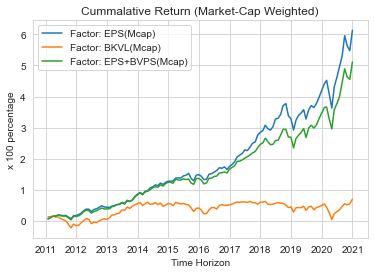

In [75]:
plt.plot((1+df_idx_Return_mcap_eps_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS(Mcap)')
plt.plot((1+df_idx_Return_mcap_bkvlps_TopDecile.set_index('date')).cumprod()-1, label='Factor: BKVL(Mcap)')
plt.plot((1+df_idx_Return_Mcap_MultiFactor_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS+BVPS(Mcap)')
plt.xlabel('Time Horizon')
plt.ylabel('x 100 percentage')
plt.legend()
plt.title('Cummalative Return (Market-Cap Weighted)')
plt.show()

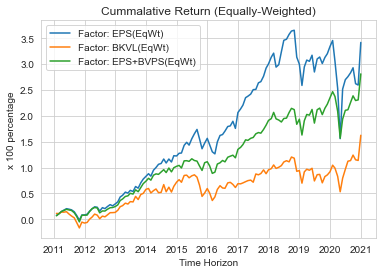

In [76]:
plt.plot((1+df_idx_Return_eqwt_eps_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS(EqWt)')
plt.plot((1+df_idx_Return_eqwt_bkvlps_TopDecile.set_index('date')).cumprod()-1, label='Factor: BKVL(EqWt)')
plt.plot((1+df_idx_Return_EqWt_MultiFactor_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS+BVPS(EqWt)')
plt.xlabel('Time Horizon')
plt.ylabel('x 100 percentage')
plt.legend()
plt.title('Cummalative Return (Equally-Weighted)')
plt.show()

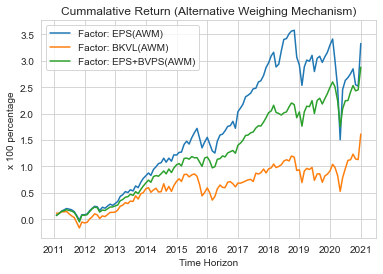

In [77]:
plt.plot((1+df_idx_Return_awm_eps_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS(AWM)')
plt.plot((1+df_idx_Return_awm_bkvlps_TopDecile.set_index('date')).cumprod()-1, label='Factor: BKVL(AWM)')
plt.plot((1+df_idx_Return_AWM_MultiFactor_TopDecile.set_index('date')).cumprod()-1, label='Factor: EPS+BVPS(AWM)')
plt.xlabel('Time Horizon')
plt.ylabel('x 100 percentage')
plt.legend()
plt.title('Cummalative Return (Alternative Weighing Mechanism)')
plt.show()

#### 2. Sharpe Ratio

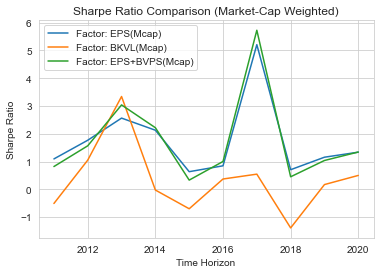

In [87]:
plt.plot(TS_Mcap_EPS['Year'], TS_Mcap_EPS['Sharpe'], label='Factor: EPS(Mcap)')
plt.plot(TS_Mcap_BKPS['Year'], TS_Mcap_BKPS['Sharpe'], label='Factor: BKVL(Mcap)')
plt.plot(TS_Mcap_MultiFactor['Year'], TS_Mcap_MultiFactor['Sharpe'], label='Factor: EPS+BVPS(Mcap)')
plt.xlabel('Time Horizon')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.title('Sharpe Ratio Comparison (Market-Cap Weighted)')
plt.show()

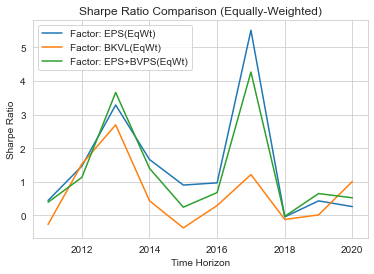

In [88]:
plt.plot(TS_EqWt_EPS['Year'], TS_EqWt_EPS['Sharpe'], label='Factor: EPS(EqWt)')
plt.plot(TS_EqWt_BKPS['Year'], TS_EqWt_BKPS['Sharpe'], label='Factor: BKVL(EqWt)')
plt.plot(TS_EqWt_MultiFactor['Year'], TS_EqWt_MultiFactor['Sharpe'], label='Factor: EPS+BVPS(EqWt)')
plt.xlabel('Time Horizon')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.title('Sharpe Ratio Comparison (Equally-Weighted)')
plt.show()

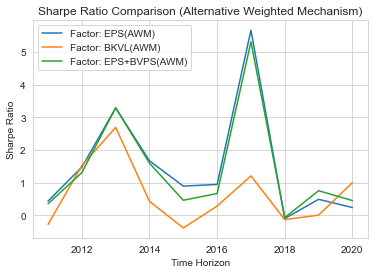

In [89]:
plt.plot(TS_AWM_EPS['Year'], TS_AWM_EPS['Sharpe'], label='Factor: EPS(AWM)')
plt.plot(TS_AWM_BKPS['Year'], TS_AWM_BKPS['Sharpe'], label='Factor: BKVL(AWM)')
plt.plot(TS_AWM_MultiFactor['Year'], TS_AWM_MultiFactor['Sharpe'], label='Factor: EPS+BVPS(AWM)')
plt.xlabel('Time Horizon')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.title('Sharpe Ratio Comparison (Alternative Weighted Mechanism)')
plt.show()

#### 3. Volatility

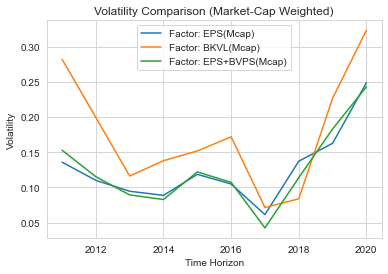

In [90]:
plt.plot(TS_Mcap_EPS['Year'], TS_Mcap_EPS['Volatility'], label='Factor: EPS(Mcap)')
plt.plot(TS_Mcap_BKPS['Year'], TS_Mcap_BKPS['Volatility'], label='Factor: BKVL(Mcap)')
plt.plot(TS_Mcap_MultiFactor['Year'], TS_Mcap_MultiFactor['Volatility'], label='Factor: EPS+BVPS(Mcap)')
plt.xlabel('Time Horizon')
plt.ylabel('Volatility')
plt.legend()
plt.title('Volatility Comparison (Market-Cap Weighted)')
plt.show()

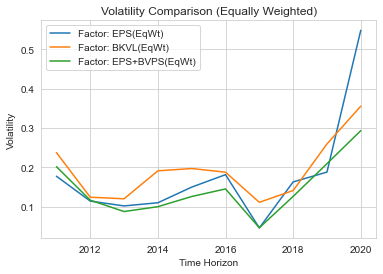

In [91]:
plt.plot(TS_EqWt_EPS['Year'], TS_EqWt_EPS['Volatility'], label='Factor: EPS(EqWt)')
plt.plot(TS_EqWt_BKPS['Year'], TS_EqWt_BKPS['Volatility'], label='Factor: BKVL(EqWt)')
plt.plot(TS_EqWt_MultiFactor['Year'], TS_EqWt_MultiFactor['Volatility'], label='Factor: EPS+BVPS(EqWt)')
plt.xlabel('Time Horizon')
plt.ylabel('Volatility')
plt.legend()
plt.title('Volatility Comparison (Equally Weighted)')
plt.show()

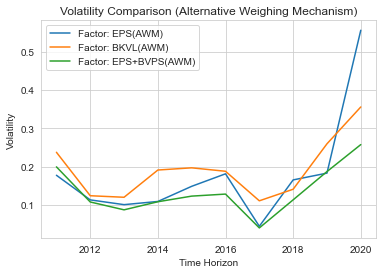

In [92]:
plt.plot(TS_AWM_EPS['Year'], TS_AWM_EPS['Volatility'], label='Factor: EPS(AWM)')
plt.plot(TS_AWM_BKPS['Year'], TS_AWM_BKPS['Volatility'], label='Factor: BKVL(AWM)')
plt.plot(TS_AWM_MultiFactor['Year'], TS_AWM_MultiFactor['Volatility'], label='Factor: EPS+BVPS(AWM)')
plt.xlabel('Time Horizon')
plt.ylabel('Volatility')
plt.legend()
plt.title('Volatility Comparison (Alternative Weighing Mechanism)')
plt.show()

#### 4. Turnover

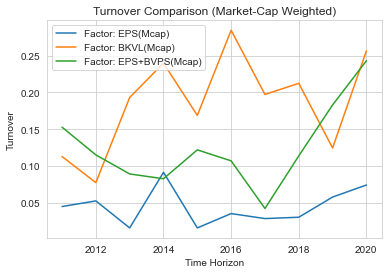

In [93]:
plt.plot(TS_Mcap_EPS['Year'], TS_Mcap_EPS['Turnover'], label='Factor: EPS(Mcap)')
plt.plot(TS_Mcap_BKPS['Year'], TS_Mcap_BKPS['Turnover'], label='Factor: BKVL(Mcap)')
plt.plot(TS_Mcap_MultiFactor['Year'], TS_Mcap_MultiFactor['Volatility'], label='Factor: EPS+BVPS(Mcap)')
plt.xlabel('Time Horizon')
plt.ylabel('Turnover')
plt.legend()
plt.title('Turnover Comparison (Market-Cap Weighted)')
plt.show()

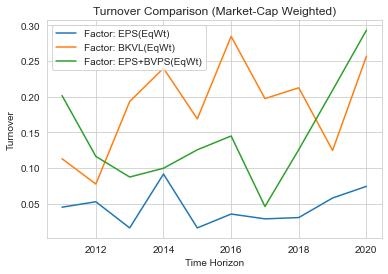

In [95]:
plt.plot(TS_EqWt_EPS['Year'], TS_EqWt_EPS['Turnover'], label='Factor: EPS(EqWt)')
plt.plot(TS_EqWt_BKPS['Year'], TS_EqWt_BKPS['Turnover'], label='Factor: BKVL(EqWt)')
plt.plot(TS_EqWt_MultiFactor['Year'], TS_EqWt_MultiFactor['Volatility'], label='Factor: EPS+BVPS(EqWt)')
plt.xlabel('Time Horizon')
plt.ylabel('Turnover')
plt.legend()
plt.title('Turnover Comparison (Market-Cap Weighted)')
plt.show()

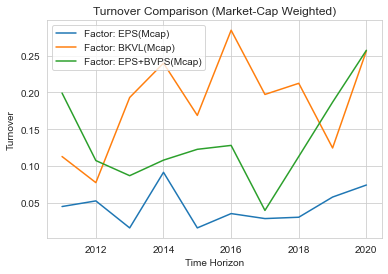

In [96]:
plt.plot(TS_AWM_EPS['Year'], TS_AWM_EPS['Turnover'], label='Factor: EPS(Mcap)')
plt.plot(TS_AWM_BKPS['Year'], TS_AWM_BKPS['Turnover'], label='Factor: BKVL(Mcap)')
plt.plot(TS_AWM_MultiFactor['Year'], TS_AWM_MultiFactor['Volatility'], label='Factor: EPS+BVPS(Mcap)')
plt.xlabel('Time Horizon')
plt.ylabel('Turnover')
plt.legend()
plt.title('Turnover Comparison (Market-Cap Weighted)')
plt.show()